<a href="https://colab.research.google.com/github/bradleywjenks/CIVE_70019_70057/blob/main/notebooks/hydraulic_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hydraulic modelling in water distribution networks
### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London\
June 2023

### Preamble
This notebook walks through code implementation for developing a solver to simulate hydraulics in water distribution networks (WDNs). Specifically, we cover the following items:
- Using the `wntr` Python package for WDN analysis
- System of mass and energy conservation equations
- Newton-Raphson method for solving system of nonlinear equations
- Block factorisation and the Schur complement
- Application of hydraulic solver on different case networks
- Remarks on computational performance

First, we must clone the repository and install dependencies.

In [86]:
# Run this cell if in Google Colab
!git clone https://github.com/bradleywjenks/CIVE_70019_70057.git
!pip install wntr
!apt-get install libsuitesparse-dev && pip install scikit-sparse

fatal: destination path 'CIVE_70019_70057' already exists and is not an empty directory.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsuitesparse-dev is already the newest version (1:5.10.1+dfsg-4build1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


### WNTR Python package

The Water Network Tool for Resilience (WNTR) Python package for simulating WDNs. It is based on the EPANET solvers. Here, we will be using `wntr` to load network data (.inp file) and compare hydraulic simulation results with our own solver.

#### Using WNTR's hydraulic solver
The code below follows an example from the `wntr` documentation: https://wntr.readthedocs.io/en/latest/index.html. Note that we have uploaded four (4) network (.inp) files for use in this notebook.

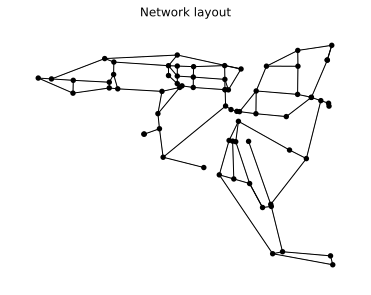

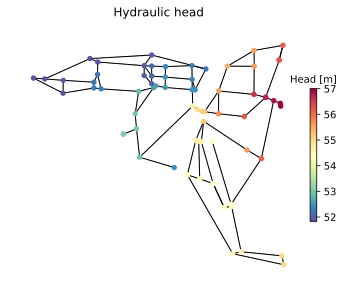

In [87]:
# Load dependencies
import os
import wntr

# net_name = 'demo.inp'
net_name = 'pescara.inp'
# net_name = 'BWSnet.inp'
# net_name = 'bwfl_2022_05_hw.inp'

# Create water network model
# os.chdir('..'); net_dir = os.path.join(os.getcwd(), 'data/networks/') # if run locally
net_dir = '/content/CIVE_70019_70057/data/networks/' # if run in Google Colab
wn = wntr.network.WaterNetworkModel(os.path.join(net_dir, net_name))

# Graph the network
wntr.graphics.plot_network(wn, title='Network layout', node_size=30)

# Simulate hydraulics
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

# Plot results on the network
hydraulic_state = 'head' # or 'flow' or 'head'

if hydraulic_state == 'head':
    head = results.node['head'].loc[0, :]
    wntr.graphics.plot_network(wn, node_attribute=head,
                            title='Hydraulic head', node_colorbar_label='Head [m]', node_size=30)
elif hydraulic_state == 'pressure':
    pressure = results.node['pressure'].loc[0, :]
    wntr.graphics.plot_network(wn, node_attribute=pressure,
                            title='Pressure head', node_colorbar_label='Pressure [m]', node_size=30)
elif hydraulic_state == 'flow':
    flow = results.link['flowrate'].loc[0, :]
    wntr.graphics.plot_network(wn, link_attribute=flow,
                            title='Link flow', link_colorbar_label='Flow [L/s]', node_size=0)

#### Data extraction
We will now use WNTR to extract network data for developing our own hydraulic solver.

In [67]:
# Load additional dependencies
import networkx as nx
import pandas as pd
import numpy as np
import scipy.sparse as sp

Get network elements and simulation information.

In [68]:
'''
    nt = number of discrete time steps
    nn = number of demand or junction nodes
    np = number of links
    n0 = number of source (reservoir) nodes
'''

nt = int(wn.options.time.duration / wn.options.time.hydraulic_timestep)
nt = nt if nt>0 else 1
net_info = dict(
    np=wn.num_links,
    nn=wn.num_junctions,
    n0=wn.num_reservoirs,
    nt=nt,
    headloss=wn.options.hydraulic.headloss,
    units=wn.options.hydraulic.inpfile_units,
    reservoir_names=wn.reservoir_name_list,
    junction_names=wn.junction_name_list,
    pipe_names=wn.pipe_name_list,
    valve_names=wn.valve_name_list,
    prv_names=wn.prv_name_list
)

Extract link data.

In [69]:
# Check head loss model
if net_info['headloss'] == 'H-W':
    n_exp = 1.852
elif net_info['headloss'] == 'D-W':
    n_exp = 2

# NB: 'C' denotes roughness or HW coefficient for pipes and local (minor) loss coefficient for valves
link_df = pd.DataFrame(
    index=pd.RangeIndex(net_info['np']),
    columns=['link_ID', 'link_type', 'diameter', 'length', 'n_exp', 'C', 'node_out', 'node_in'],
)
def link_dict(link):
    if isinstance(link, wntr.network.Pipe):  # check if the link is a pipe
        return dict(
            link_ID=link.name,
            link_type='pipe',
            diameter=link.diameter,
            length=link.length,
            n_exp=n_exp,
            C=link.roughness,
            node_out=link.start_node_name,
            node_in=link.end_node_name
        )
    elif isinstance(link, wntr.network.Valve): # check if the link is a valve
        return dict(
            link_ID=link.name,
            link_type='valve',
            diameter=link.diameter,
            length=2*link.diameter,
            n_exp=2,
            C=link.minor_loss,
            node_out=link.start_node_name,
            node_in=link.end_node_name
        )

for idx, link in enumerate(wn.links()):
    link_df.loc[idx] = link_dict(link[1])

link_df

,link_ID,link_type,diameter,length,n_exp,C,node_out,node_in
0,1,pipe,0.1,977.36,1.852,98.0,1,2
1,2,pipe,0.15,443.17,1.852,115.0,3,4
2,3,pipe,0.1,1410.77,1.852,62.0,3,5
3,4,pipe,0.125,269.61,1.852,102.0,3,1
4,6,pipe,0.1,203.06,1.852,95.0,6,8
...,...,...,...,...,...,...,...,...
93,106,pipe,0.1,332.35,1.852,125.0,55,88
94,107,pipe,0.1,325.03,1.852,82.0,88,51
95,108,pipe,0.1,113.35,1.852,93.0,84,88
96,109,pipe,0.1,150.82,1.852,90.0,88,89


Extract node data.

In [70]:
node_df = pd.DataFrame(
    index=pd.RangeIndex(wn.num_nodes), columns=["node_ID", "elev", "xcoord", "ycoord"]
)

def node_dict(node):
    if isinstance(node, wntr.network.elements.Reservoir):
        elev = 0
    else:
        elev = node.elevation
    return dict(
        node_ID=node.name,
        elev=elev,
        xcoord=node.coordinates[0],
        ycoord=node.coordinates[1]
    )

for idx, node in enumerate(wn.nodes()):
    node_df.loc[idx] = node_dict(node[1])

node_df

,node_ID,elev,xcoord,ycoord
0,1,2.9,656582.88,963296.25
1,2,5.0,657289.06,963069.5
2,3,3.5,656852.19,963283.19
3,4,3.8,657294.63,963262.25
4,5,2.2,657933.44,963588.94
...,...,...,...,...
65,88,2.1,659408.69,963325.81
66,89,1.5,659408.69,963476.63
67,15,0,662492.56,962874.81
68,43,0,658738.69,962454.75


Create network graph.

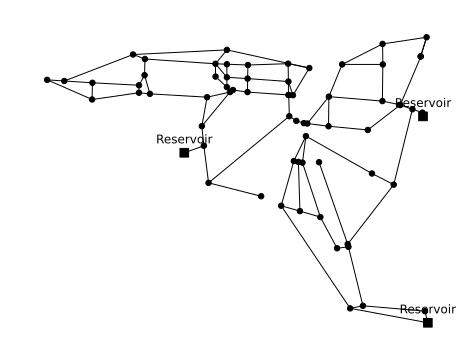

In [71]:
# extract network as a graph
# G = wn.to_graph()
# uG = G.to_undirected() # change to undirected graph structure
uG = nx.from_pandas_edgelist(link_df, source='node_out', target='node_in')
pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in node_df.iterrows()}
reservoir_labels = {node: 'Reservoir' for node in net_info['reservoir_names']}

# draw entire network
nx.draw(uG, pos, node_size=30, node_shape='o', node_color='black')
# draw reservoir nodes
nx.draw_networkx_nodes(uG, pos, nodelist=net_info['reservoir_names'], node_size=75, node_shape='s', node_color='black')
# reservoir labels
labels = nx.draw_networkx_labels(uG, pos, reservoir_labels, font_size=12, verticalalignment='bottom')
for _, label in labels.items():
    label.set_y(label.get_position()[1] + 80)


# create adjacency matrices
A = np.zeros((net_info['np'], net_info['nn']+net_info['n0']), dtype=int)
for k, row in link_df.iterrows():
    # find start node
    out_name = row['node_out']
    out_idx = node_df[node_df['node_ID']==out_name].index[0]
    # find end node
    in_name = row['node_in']
    in_idx = node_df[node_df['node_ID']==in_name].index[0]

    A[k, out_idx] = -1
    A[k, in_idx] = 1

junction_idx = node_df.index[node_df['node_ID'].isin(net_info['junction_names'])].tolist()
reservoir_idx = node_df.index[node_df['node_ID'].isin(net_info['reservoir_names'])].tolist()

# incident matrices
A12 = A[:, junction_idx]; A12 = sp.csr_matrix(A12) # link-junction incident matrix
A10 = A[:, reservoir_idx]; A10 = sp.csr_matrix(A10) # link-reservoir indicent matrix

Extract operational data (e.g. demands, boundary heads).

In [51]:
# demand data
demand_df = results.node['demand'].T
col_names = [f'demands_{t}' for t in range(1, len(demand_df.columns)+1)]
demand_df.columns = col_names
demand_df.reset_index(drop=False, inplace=True)
demand_df = demand_df.rename(columns={'name': 'node_ID'})

if net_info['nt'] > 1:
    demand_df = demand_df.iloc[:, :-1] # delete last time step

demand_df = demand_df[~demand_df['node_ID'].isin(net_info['reservoir_names'])] # delete reservoir nodes
demand_df

,node_ID,demands_1,demands_2,demands_3,demands_4,demands_5,demands_6,demands_7,demands_8,demands_9,...,demands_15,demands_16,demands_17,demands_18,demands_19,demands_20,demands_21,demands_22,demands_23,demands_24
0,1,0.001368,0.001368,0.000701,0.000701,0.000701,0.000701,0.002035,0.002035,0.003437,...,0.002402,0.002402,0.002769,0.002769,0.002402,0.002402,0.002069,0.001368,0.001368,0.001368
1,2,0.001699,0.001699,0.000870,0.000870,0.000870,0.000870,0.002527,0.002527,0.004268,...,0.002983,0.002983,0.003439,0.003439,0.002983,0.002983,0.002569,0.001699,0.001699,0.001699
2,3,0.001162,0.001162,0.000595,0.000595,0.000595,0.000595,0.001728,0.001728,0.002918,...,0.002040,0.002040,0.002352,0.002352,0.002040,0.002040,0.001757,0.001162,0.001162,0.001162
3,4,0.001162,0.001162,0.000595,0.000595,0.000595,0.000595,0.001728,0.001728,0.002918,...,0.002040,0.002040,0.002352,0.002352,0.002040,0.002040,0.001757,0.001162,0.001162,0.001162
4,5,0.001656,0.001656,0.000848,0.000848,0.000848,0.000848,0.002464,0.002464,0.004161,...,0.002909,0.002909,0.003353,0.003353,0.002909,0.002909,0.002505,0.001656,0.001656,0.001656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,85,0.000051,0.000051,0.000026,0.000026,0.000026,0.000026,0.000075,0.000075,0.000127,...,0.000089,0.000089,0.000102,0.000102,0.000089,0.000089,0.000076,0.000051,0.000051,0.000051
63,86,0.000883,0.000883,0.000452,0.000452,0.000452,0.000452,0.001314,0.001314,0.002218,...,0.001550,0.001550,0.001787,0.001787,0.001550,0.001550,0.001335,0.000883,0.000883,0.000883
64,87,0.003417,0.003417,0.001750,0.001750,0.001750,0.001750,0.005083,0.005083,0.008583,...,0.006000,0.006000,0.006917,0.006917,0.006000,0.006000,0.005167,0.003417,0.003417,0.003417
65,88,0.000294,0.000294,0.000151,0.000151,0.000151,0.000151,0.000437,0.000437,0.000738,...,0.000516,0.000516,0.000595,0.000595,0.000516,0.000516,0.000444,0.000294,0.000294,0.000294


In [52]:
# boundary head data
h0_df = results.node['head'].T
col_names = [f'h0_{t}' for t in range(1, len(h0_df.columns)+1)]
h0_df.columns = col_names
h0_df.reset_index(drop=False, inplace=True)
h0_df = h0_df.rename(columns={'name': 'node_ID'})

if net_info['nt'] > 1:
    h0_df = h0_df.iloc[:, :-1] # delete last time step

h0_df = h0_df[h0_df['node_ID'].isin(net_info['reservoir_names'])] # only reservoir nodes
h0_df

,node_ID,h0_1,h0_2,h0_3,h0_4,h0_5,h0_6,h0_7,h0_8,h0_9,...,h0_15,h0_16,h0_17,h0_18,h0_19,h0_20,h0_21,h0_22,h0_23,h0_24
67,15,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,...,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
68,43,53.080002,53.080002,53.080002,53.080002,53.080002,53.080002,53.080002,53.080002,53.080002,...,53.080002,53.080002,53.080002,53.080002,53.080002,53.080002,53.080002,53.080002,53.080002,53.080002
69,65,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000


<span style="color:red">**NB: The above code comprise functions 'load_network_data' and 'plot_network' in the file '~/src/general_functions.py'**.</span>

### Newton-Raphson hydraulic solver
We will now develop our own hydraulic solver using the Newton-Raphson method for solving nonlinear systems of equations.

#### System of nonlinear equations
Hydraulic states are computed for each time step $t \in \{1, \dots, n_t\}$, where $n_t$ denotes the number of discrete time steps in the simulation period. These comprise the following unknown variables for which we wish to solve:
- Flow rate $q_t \in \mathbb{R}^{n_p}$ conveyed across network links, where $n_p$ is the number of links
- Hydraulic head $h_t \in \mathbb{R}^{n_n}$ at network nodes, where $n_n$ is the number of junction nodes

Their solution is governed by **energy** and **mass** conservation equations, as follows:

\begin{equation}
    A_{11}(q_t)q_t + A_{12}h_t + A_{10}h_{0t} = 0 \\
    A_{12}^{T}q_t + d_t = 0,
\label{eq:hydraulic} \tag{1}
\end{equation}

where
- $A_{11} \in \mathbb{R}^{n_p \times n_p} = k_j|q_j^{n-1}|, \;\, \forall j \in \{1, \dots, n_p\}$ is a diagonal matrix of frictional head losses and $k_j$ is the pipe or valve resistance coefficient
- $A_{12} \in \mathbb{R}^{n_p \times n_n}$ is the link-node incidence matrix
- $A_{10} \in \mathbb{R}^{n_p \times n_0}$ is the link-known head incidence matrix
- $d_t \in \mathbb{R}^{n_n}$ is the vector of known demands (i.e. loading conditions)
- $h_{0t} \in \mathbb{R}^{n_0}$ is the vector of known hydraulic heads (i.e. boundary conditions)

Since the same equations are applied for all time steps, we omit the index $t$ henceforth. The system of nonlinear equations in \eqref{eq:hydraulic} is written in matrix form, as follows:

\begin{equation}
 F(q,h):= \left[
    {\renewcommand{\arraystretch}{1.5}
        \begin{array}{cc}
            A_{11}(q) & A_{12}  \\
            A_{12}^{T} & 0 \\
        \end{array}}\right]
    \left[
    {\renewcommand{\arraystretch}{1.5}
        \begin{array}{c}
            q \\
            h \\
        \end{array}}\right] -
    \left[
    {\renewcommand{\arraystretch}{1.5}
        \begin{array}{c}
            -A_{10}h_0 \\
            d \\
        \end{array}}\right] = 0.
\label{eq:hydraulic_matrix} \tag{2}
\end{equation}

#### Newton-Raphson method
We can then apply the Newton-Raphson method to solve the system of nonlinear equations in \eqref{eq:hydraulic_matrix}. The Newton-Raphson method is an iterative numerical technique for finding the root of an equation. At each iteration $k$, a new estimate of the root is found using the following formula:

\begin{equation}
    x^{k+1} = x^k - J(x^k)^{-1}F(x^k),
\label{eq:newton_raphson_1} \tag{3}
\end{equation}

where $J(x)$ is the Jacobian, a matrix of first-order partial derivatives. In general form, if $F(x)$ has $m$ equations, $f_1,f_2,\dots,f_m$, and $n$ variables, $x_1,x_2,\dots,x_n$, as

\begin{equation}
    F(x)= \left[\begin{array}{c}
    f_1(x_1,\cdot,x_n)\\
    \vdots\\
    f_m(x_1,\cdot,x_n)\\
    \end{array}\right],
\label{eq:general_function} \tag{4}
\end{equation}

then the Jacobian $J(x)$ is expressed mathematically as follows:

\begin{equation}
    J(x) =\left[\begin{array}{cccc}
    \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} & \cdots & \frac{\partial f_1}{\partial x_n}\\
    \frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} & \cdots & \frac{\partial f_2}{\partial x_n}\\
    \vdots & \vdots & \ddots & \vdots\\
    \frac{\partial f_m}{\partial x_1} & \frac{\partial f_m}{\partial x_2} & \cdots & \frac{\partial f_m}{\partial x_n}\\
    \end{array}\right].
\label{eq:jacobian} \tag{5}
\end{equation}

#### Hydraulic solver
We now define the Jacobian $J(x)$ and Newton-Raphson steps to compute a unique solution to the hydraulic model in \eqref{eq:hydraulic}. The system of nonlinear equations,

\begin{equation}
F(q, h) := \left\lbrace \begin{array}{ll}
    f_1(q,h) = A_{11}(q)q + A_{12}h + A_{10}h_0 = 0 \\
    f_2(q,h) = A_{21}q - d = 0,
\end{array}\right.
\label{eq:nonlinear_system} \tag{6}
\end{equation}

has a Jacobian computed as

\begin{equation}
J (q, h) := \left\lbrace \begin{array}{ll}
    \frac{\partial f_1 }{\partial q}=\frac{\partial A_{11}(q)q}{\partial q}=\frac{\partial K|q^{n-1}|q}{\partial q}={N Kq}^{n-1} ={NA_{11}(q)} \\
    \frac{\partial f_1 }{\partial h}=\frac{\partial A_{12} h}{\partial h}=A_{12} \\
    \frac{\partial f_2 }{\partial q}=\frac{\partial A_{12}^T q}{\partial q}=A_{12}^T \\
    \frac{\partial f_2 }{\partial h}=0,
\end{array}\right.
\label{eq:jacobian_hydraulic} \tag{7}
\end{equation}

which can be written in matrix form as

\begin{equation}
    J(q,h)=\left[\begin{array}{cc}
    \frac{\partial f_1}{\partial q} & \frac{\partial f_1}{\partial h} \\
    \frac{\partial f_2}{\partial q} & \frac{\partial f_2}{\partial h} \\
    \end{array}\right]=\left[\begin{array}{cc}
    NA_{11}(q) & {A_{12}} \\
    {A_{12}^T} & 0 \\
    \end{array}\right], \; \text{where} \;
    N=\left[\begin{array}{cccc}
        n & 0 & \cdots & 0 \\
        0 & n & \cdots & 0 \\
        \vdots & \vdots & \ddots & 0 \\
        0 & 0 & \cdots & n \\
    \end{array}\right].
\label{eq:jacobian_hydraulic_matrix} \tag{8}
\end{equation}

However, computing the inverse of the Jacobian is not computationally efficient (at every iteration) and it may not be possible for singular matrices (i.e. zero-flow pipes). We therefore multiply both sides of \eqref{eq:newton_raphson_1} by $J(x^k)$ to eliminate its inverse:

\begin{equation}
    J(x^k)x^{k+1}=J(x^k)x^k-F(x^k).
\label{eq:newton_raphson_2} \tag{9}
\end{equation}

Each new iterate $x_{k+1}$ of the Newton-Raphson equation is computed by solving the following linear system:

\begin{equation}
    \left[\begin{array}{cc}
         NA_{11}(h_k)& A_{12} \\
         A_{12}^T& 0 \\
    \end{array}\right]
    \left[\begin{array}{c}
         q^{k+1} \\
         h^{k+1} \\
    \end{array}\right] =
    \left[\begin{array}{cc}
         NA_{11}(q^{k})& A_{12}  \\
         A_{12}^T& 0 \\
    \end{array}\right]
    \left[\begin{array}{c}
         q^{k} \\
         h^{k} \\
    \end{array}\right] - \left[\left[\begin{array}{cc}
         A_{11}(q^{k})& A_{12} \\
         A_{12}^T& 0\\
    \end{array}\right]
    \left[\begin{array}{c}
         q^{k} \\
         h^{k} \\
    \end{array}\right]+\left[\begin{array}{c}
         A_{10}h_0 \\
         -d\\
    \end{array}\right]\right],
\label{eq:newton_step_1} \tag{10}
\end{equation}

which simplifies to,

\begin{equation}
    \left[\begin{array}{cc}
         NA_{11}(q^k)& A_{12} \\
         A_{12}^T & 0\\
    \end{array}\right] \left[\begin{array}{c}
          q^{k+1} \\
          h^{k+1} \\
    \end{array}\right]=
    \left[\begin{array}{c}
         (N-I)A_{11}(q^k)q^k-A_{10}h_0\\
         d\\
    \end{array}\right].
\label{eq:newton_step_2} \tag{11}
\end{equation}

At each iteration $k$, we perform the following convergence check:

\begin{equation}
\begin{Vmatrix}
        A_{11}(q^{k+1})q^{k+1} + A_{12}h^{k+1} + A_{10}h_0 \\
        A_{12}^Tq^{k+1} - d
\end{Vmatrix}
    _{\infty} < \epsilon_{\text{tol}}
\label{eq:convergence_check} \tag{12}
\end{equation}

where the solver has converged if the maximum error is less than a specified tolerance $\epsilon_{\text{tol}}$. The solution process for using the Newton-Raphson method for solving the system of nonlinear equations is shown in the figure below.

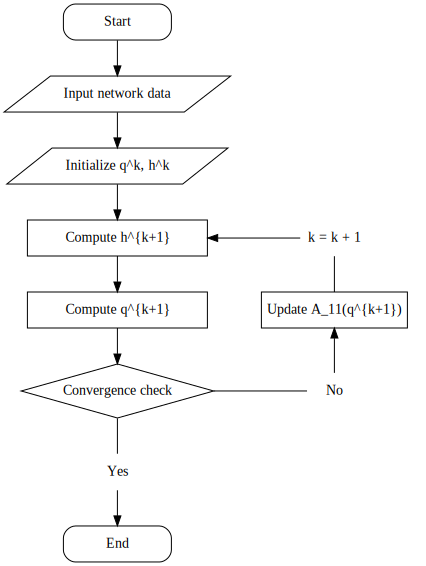

In [53]:
# code for generating solution process chart
from graphviz import Digraph

dot = Digraph()

# Add nodes
dot.node("start", label="Start", shape="rect", width="1.5", height="0.5", style="rounded")
dot.node("input", label="Input network data", shape="parallelogram")
dot.node("initial", label="Initialize q^k, h^k", shape="parallelogram")
dot.node("end", label="End", shape="rect", width="1.5", height="0.5", style="rounded")
dot.node("convergence", label="Convergence check", shape="diamond", width="1.0", height="0.75")
dot.node("compute_h", label="Compute h^{k+1}", shape="rect", width="2.5")
dot.node("compute_q", label="Compute q^{k+1}", shape="rect", width="2.5")
dot.node("update", label="Update A_11(q^{k+1})", shape="rect")
dot.node("convergence", label="Convergence check", shape="diamond", width="1.0", height="0.75")
dot.node("dummy_1", label="No", shape="plaintext", width="0.75", height="0.5")
dot.node("dummy_2", label="k = k + 1", shape="plaintext", width="0.75", height="0.5")
dot.node("dummy_3", label="Yes", shape="plaintext", width="0.75", height="0.5")

# Add edges
dot.edge("start", "input")
dot.edge("input", "initial")
dot.edge("convergence", "dummy_3", dir="none")
dot.edge("dummy_3", "end")
dot.edge("initial", "compute_h")
dot.edge("compute_h", "compute_q", headport="n", tailport="s")
dot.edge("compute_q", "convergence", headport="n", tailport="s")
dot.edge("dummy_1", "update", headport="s")
dot.edge("dummy_2", "update", dir="none", headport="n")

# Subgraphs
with dot.subgraph(name="same_level_1") as s1:
    s1.attr(rank="same")
    s1.edge("compute_q", "update", style="invis", minlen="3")
with dot.subgraph(name="same_level_2") as s2:
    s2.attr(rank="same")
    s2.edge("convergence", "dummy_1", dir="none")
with dot.subgraph(name="same_level_3") as s3:
    s3.attr(rank="same")
    s3.edge("compute_h", "dummy_2", dir="back", minlen="2")
with dot.subgraph(name="same_level_4") as s4:
    s4.attr(rankdir="TB")
    s4.edge("dummy_1", "dummy_2", style="invis")
with dot.subgraph(name="same_level_5") as s5:
    s5.attr(rank="TB")
    s5.edge("compute_h", "compute_q", style="invis")
    s5.edge("compute_q", "convergence", style="invis")

# View flowchart
dot

Below is code for implementing the Newton-Raphson solver described above.

In [88]:
## if run locally
# from src import general_functions as gen_fn

# if run in Google Colab
libdir = "/content/CIVE_70019_70057/src/"
%run {libdir}general_functions.py
%run {libdir}hydraulic_functions.py

/content/CIVE_70019_70057/src/general_functions.py:31: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')
/content/CIVE_70019_70057/src/hydraulic_functions.py:33: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


<Figure size 1920x1440 with 0 Axes>

First, we use previously written code (now in a function) to load network data. We have to load these functions as follows.

In [89]:
# if run in Google Colab
libdir = "/content/CIVE_70019_70057/src/"
%run {libdir}general_functions.py
%run {libdir}hydraulic_functions.py

/content/CIVE_70019_70057/src/general_functions.py:31: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')
/content/CIVE_70019_70057/src/hydraulic_functions.py:33: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


Then, we can load network data using the previously defined function 'load_network_data'

In [90]:
# net_name = 'demo.inp'
net_name = 'pescara.inp'
# net_name = 'BWSnet.inp'
# net_name = 'bwfl_2022_05_hw.inp'

wdn = load_network_data(os.path.join(net_dir, net_name))

The network layout is plotted below.

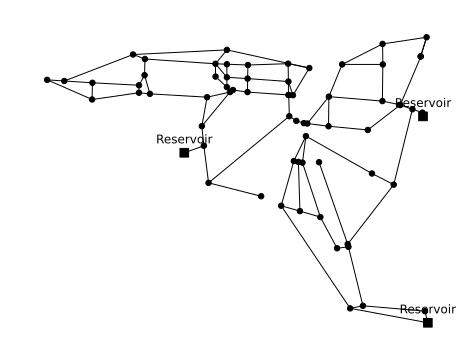

In [91]:
plot_network(wdn)

Code for the Newton-Raphson solver is below.

In [92]:
### Step 1: unload network and hydraulic data
A12 = wdn.A12
A10 = wdn.A10
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df
h0_df = wdn.h0_df

# define head loss equations
def friction_loss(net_info, df):
    if net_info['headloss'] == 'H-W':
        K = 10.67 * df['length'] * (df['C'] ** -df['n_exp']) * (df['diameter'] ** -4.8704)
    else:
        K = [] # insert DW formula here...

    return K

def local_loss(df):
    K = (8 / (np.pi ** 2 * 9.81)) * (df['diameter'] ** -4) * df['C']

    return K

# compute loss coefficients
K = np.zeros((net_info['np'], 1))
for idx, row in link_df.iterrows():
    if row['link_type'] == 'pipe':
        K[idx] = friction_loss(net_info, row)

    elif row['link_type'] == 'valve':
        K[idx] = local_loss(row)

n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)

# set stopping criteria
tol = 1e-5
kmax = 50

# small values in A11 make convergence unsteady; therefore, we need to define a lower bound -- see Todini (1988), page 7
tol_A11 = 1e-5

# set solution arrays
q = np.zeros((net_info['np'], net_info['nt']))
h = np.zeros((net_info['nn'], net_info['nt']))


# run over all time steps
for t in range(net_info['nt']):

    ### Step 2: set initial values
    hk = 130 * np.ones((net_info['nn'], 1))
    qk = 0.03 * np.ones((net_info['np'], 1))

    # set boundary head and demand conditions
    dk = demand_df.iloc[:, t+1].to_numpy(); dk = dk.reshape(-1, 1)
    h0k = h0_df.iloc[:, t+1].to_numpy(); h0k = h0k.reshape(-1, 1)

    # initialise A11 matrix
    A11_diag = K * (abs(qk) ** (n_exp - 1)) # diagonal elements of matrix A11
    A11_diag[A11_diag < tol_A11] = tol_A11 # replace with small value = tol_A11
    A11 = sp.diags(A11_diag.T, [0]) # matrix A11, allocated as a sparse diagonal matrix

    # begin iterations
    for k in range(kmax):

        ### Step 3: compute h^{k+1} and q^{k+1} for each iteration k
        N = sp.diags(n_exp.T, [0]) # matrix N
        I = sp.eye(net_info['np'], format='csr') # identiy matrix with dimension np x np, allocated as a sparse matrix

        b = np.concatenate([(N - I) @ A11 @ qk - A10 @ h0k, dk])
        J = sp.bmat([[N @ A11, A12], [A12.T, sp.csr_matrix((net_info['nn'], net_info['nn']))]], format='csr')

        # solve linear system
        x = sp.linalg.spsolve(J, b)
        qk = x[:net_info['np']]; qk = qk.reshape(-1, 1)
        hk = x[net_info['np']:net_info['np'] + net_info['nn']];hk = hk.reshape(-1, 1)

        # update A11 matrix
        A11_diag = K * (abs(qk) ** (n_exp - 1)) # diagonal elements of matrix A11
        A11_diag[A11_diag < tol_A11] = tol_A11 # replace with small value = tol_A11
        A11 = sp.diags(A11_diag.T, [0]) # matrix A11, allocated as a sparse diagonal matrix


        ### Step 4: convergence check
        err = A11 @ qk + A12 @ hk + A10 @ h0k
        max_err = np.linalg.norm(err, np.inf)

        # print progress
        print(f"Time step t={t+1}, Iteration k={k}. Maximum energy conservation error is {max_err} m.")

        if max_err < tol:
            # if successful,  break from loop
            break

    q[:, t] = qk.T
    h[:, t] = hk.T

# convert results to pandas dataframe
column_names_q = [f'q_{t+1}' for t in range(net_info['nt'])]
q_df = pd.DataFrame(q, columns=column_names_q)
q_df.insert(0, 'link_ID', link_df['link_ID'])

column_names_h = [f'h_{t+1}' for t in range(net_info['nt'])]
h_df = pd.DataFrame(h, columns=column_names_h)
h_df.insert(0, 'link_ID', link_df['link_ID'])


Time step t=1, Iteration k=0. Maximum energy conservation error is 272.50556746170014 m.
Time step t=1, Iteration k=1. Maximum energy conservation error is 44.38750593780825 m.
Time step t=1, Iteration k=2. Maximum energy conservation error is 10.392667774545082 m.
Time step t=1, Iteration k=3. Maximum energy conservation error is 2.554115916567548 m.
Time step t=1, Iteration k=4. Maximum energy conservation error is 0.652625617988466 m.
Time step t=1, Iteration k=5. Maximum energy conservation error is 0.23182853653983648 m.
Time step t=1, Iteration k=6. Maximum energy conservation error is 0.10743247995032726 m.
Time step t=1, Iteration k=7. Maximum energy conservation error is 0.02199691062762371 m.
Time step t=1, Iteration k=8. Maximum energy conservation error is 0.0005401792146697837 m.
Time step t=1, Iteration k=9. Maximum energy conservation error is 4.031730649750598e-07 m.
Time step t=2, Iteration k=0. Maximum energy conservation error is 272.50556746170014 m.
Time step t=2, 

<span style="color:red">**NB: The above code comprises a function 'hydraulic_solver' in the file '~/src/hydraulic_functions.py'**.</span>

### Newton-Raphson solver with Schur complement

We note that the system of linear equations in \eqref{eq:newton_step_2} has a saddle point form. We can leverage this special structure to improve the computational performance of the Newton-Raphson solver.

#### Saddle point problem
Let us first present the Newton-Raphson step as a general linear system with saddle point form, as folllows:

\begin{equation}
\left[\begin{array}{cc}
     A&B_{1}  \\
     B_{2}^T & C \\
\end{array}\right] \left[\begin{array}{c}
     x \\
    y \\
\end{array}\right]=\left[\begin{array}{c}
     f  \\
     g \\
\end{array}\right], \; \text{or} \; \mathcal{A}u=b
\label{eq:saddle_point} \tag{13}
\end{equation}

where the block matrices in \eqref{eq:saddle_point} must satisfy the following conditions:
1. $A \succeq 0$ is symmetric positive semidefinite
2. $B_1 = B_2 = B$
3. $C \succeq 0$ is symmetric positive semidefinite

In the Newton-Raphson step for our hydraulic simulation \eqref{eq:newton_step_2}, these variables are defined as:
- $A=NA_{11}(q_k)$
- $B = A_{12}$
- $C = O$ (zero matrix)
- $x = q^{k+1}$
- $y = h^{k+1}$
- $f = (N-I)A_{11}(q^k)q^k-A_{10}h_0$
- $g = d$

#### Block factorisation and the Schur complement
If A is nonsingular, the saddle point matrix $\mathcal{A}$ admits the following block triangular factorization:

\begin{equation}
    \mathcal{A}=\left[\begin{array}{cc}
     A&B_1  \\
     B_2^T& O \\
\end{array}\right] =\left[\begin{array}{cc}
     I & O \\
    B_2^TA^{-1} & I \\
\end{array}\right] \left[\begin{array}{cc}
     A & O  \\
     O & S \\
\end{array}\right] \left[\begin{array}{cc}
     I & A^{-1}B_1 \\
     O & I \\
\end{array}\right]
\label{saddle_property_1} \tag{14}
\end{equation}

\begin{equation}
    \mathcal{A} = \left[\begin{array}{cc}
     A & O  \\
     B_2^T & S \\
\end{array}\right] \left[\begin{array}{cc}
     I & A^{-1}B_1 \\
     O & I \\
\end{array}\right]
\label{saddle_property_2} \tag{15}
\end{equation}

\begin{equation}
    \mathcal{A} = \left[\begin{array}{cc}
     I & O  \\
     B_2^TA^{-1} & I \\
\end{array}\right] \left[\begin{array}{cc}
     A & B_1 \\
     O & S \\
\end{array}\right]
\label{saddle_property_3} \tag{16}
\end{equation}

where $S=-(B_2^TA^{-1}B_1)$ is the Schur complement of $A$ in $\mathcal{A}$. In our hydraulic simulation problem, the Schur complement is defined as $S=-A_{12}^T\left(NA_{11}(q^k)\right)^{-1}A_{12}$.

The following conditions must hold on the system of linear equations to ensure that $S$ and $\mathcal{A}$ are nonsingular:
1. $A$ is symmetric positive definite
2. $B$ has full column rank (i.e. $rank(B) = m$), where $m$ is the number of columns in $B$
2. $ker(A)\cap ker(B)={0}$

For the sake of brevity, we do not show a proof that $\mathcal{A}$ is nonsingular for our linear system described in \eqref{eq:newton_step_2}. We also note that, as introduced previously, it is common practice to include a small regularisation term $A_{11}{\text{_tol}}$ to the diagonal elements of $A_{11}$ to ensure it is positively defined (and is therefore invertible). This has negligible impact on the energy conservation of the network.

#### Application of Schur complement to Newton-Raphson solver
Recall the system of linear equations solved at each Newton-Raphson step,

\begin{equation}
    \left[\begin{array}{cc}
         NA_{11}(q^k)& A_{12} \\
         A_{12}^T & 0\\
    \end{array}\right] \left[\begin{array}{c}
          q^{k+1} \\
          h^{k+1} \\
    \end{array}\right]=
    \left[\begin{array}{c}
         (N-I)A_{11}(q^k)q^k-A_{10}h_0\\
         d\\
    \end{array}\right].
\label{eq:recall_newton_step} \tag{17}
\end{equation}

The above system can be written in a more expanded form

\begin{eqnarray}
   NA_{11}(q^k)q^{k+1}+A_{12}h^{k+1}&=&(N-I)A_{11}(q^k)q^k-A_{10}h_0 \label{eq:newton_step_expand_1} \tag{18}\\
    A_{12}^Tq^{k+1}&=&d \label{eq:newton_step_expand_2} \tag{19}
\end{eqnarray}

Then, multiplying $A_{12}^T\left(NA_{11}(q^k)\right)^{-1}$ to each side of \eqref{eq:newton_step_expand_1} and substituting $A_{12}^Tq^{k+1}=d$ yields

\begin{equation}
A_{12}^T\left(NA_{11}(q^k)\right)^{-1}A_{12}h^{k+1}=A_{12}^T\left(NA_{11}(q^k)\right)^{-1}\left((N-I)A_{11}(q^k)q^k-A_{10}h_0\right)-d
\tag{20}
\end{equation}

Finally, with $\left(NA_{11}(q^k)\right)^{-1}=N^{-1}\left(A_{11}(q^k)\right)^{-1}$, we have

\begin{equation}
A_{12}^TN^{-1}\left(A_{11}(q^k)\right)^{-1}A_{12}h^{k+1}=-A_{12}^TN^{-1}(q^k+\left(A_{11}(q^k)\right)^{-1}A_{10}h_0)+A_{12}^Tq^k-d
\label{eq:h_update} \tag{21}
\end{equation}

A new estimate of $h^{k+1}$ can then be computed from \eqref{eq:h_update}. Here, the symmetric positive definite matrix $A_{12}^TN^{-1}\left(A_{11}(q^k)\right)^{-1}A_{12}$ is much smaller $(n_n \times n_n)$ than the Jacobian $(n_p+n_n \times n_p+n_n)$ in the original Newton-Raphson step. It also has nice properties, allowing for the use of fast factorisation algorithms (e.g. Cholesky factorisation).

Once $h^{k+1}$ is determined, we can directly compute $q^{k+1}$ by rearanging \eqref{eq:newton_step_expand_1} and substituting in $h^{k+1}$, as follows

\begin{equation}
   q^{k+1}=-N^{-1}\left(A_{11}(q^k)\right)^{-1}A_{12}h^{k+1}+(I-N^{-1})q^k-N^{-1}\left(A_{11}(q^k)\right)^{-1}A_{10}h_0
\end{equation}

Note that this solver routine is known as the global gradient algorithm (GGA), or 'nodal' version of the original Newton-Raphson method. The GGA algorithm is used in EPANET's solver routine.

Code for implementing the Newton-Raphson solver with Schur complement is below.

In [93]:
### Step 1: unload network and hydraulic data
A12 = wdn.A12
A10 = wdn.A10
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df
h0_df = wdn.h0_df

# define head loss equations
def friction_loss(net_info, df):
    if net_info['headloss'] == 'H-W':
        K = 10.67 * df['length'] * (df['C'] ** -df['n_exp']) * (df['diameter'] ** -4.8704)
    else:
        K = [] # insert DW formula here...

    return K

def local_loss(df):
    K = (8 / (np.pi ** 2 * 9.81)) * (df['diameter'] ** -4) * df['C']

    return K

# compute loss coefficients
K = np.zeros((net_info['np'], 1))
for idx, row in link_df.iterrows():
    if row['link_type'] == 'pipe':
        K[idx] = friction_loss(net_info, row)

    elif row['link_type'] == 'valve':
        K[idx] = local_loss(row)

n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)

# set stopping criteria
tol = 1e-5
kmax = 50

# small values in A11 make convergence unsteady; therefore, we need to define a lower bound -- see Todini (1988), page 7
tol_A11 = 1e-5

# set solution arrays
q = np.zeros((net_info['np'], net_info['nt']))
h = np.zeros((net_info['nn'], net_info['nt']))


# run over all time steps
for t in range(net_info['nt']):

    ### Step 2: set initial values
    hk = 130 * np.ones((net_info['nn'], 1))
    qk = 0.03 * np.ones((net_info['np'], 1))

    # set boundary head and demand conditions
    dk = demand_df.iloc[:, t+1].to_numpy(); dk = dk.reshape(-1, 1)
    h0k = h0_df.iloc[:, t+1].to_numpy(); h0k = h0k.reshape(-1, 1)

    # initialise A11 matrix
    A11_diag = K * (abs(qk) ** (n_exp - 1)) # diagonal elements of matrix A11
    A11_diag[A11_diag < tol_A11] = tol_A11 # replace with small value = tol_A11
    A11 = sp.diags(A11_diag.T, [0]) # matrix A11, allocated as a sparse diagonal matrix

    # begin iterations
    for k in range(kmax):

        ### Step 3: compute h^{k+1} and q^{k+1}
        inv_A11_diag = 1 / A11_diag; # diagonal elements of the inverse of A11
        inv_A11 = sp.diags(inv_A11_diag.T, [0]) # inverse of A11, allocated as a sparse, diagonal matrix

        inv_N = sp.diags(1/n_exp.T, [0]) # inverse of matrix N

        DD = inv_N @ inv_A11 # matrix inv_N * inv_A11

        b = -A12.T @ inv_N @ (qk + inv_A11 @ (A10 @ h0k)) + A12.T @ qk - dk # right-hand side of linear system for finding h^{k+1]
        A = A12.T @ DD @ A12 # Schur complement

        # solve linear system for h^{k+1]
        hk = sp.linalg.spsolve(A, b); hk = hk.reshape(-1, 1)

        # solve q^{k+1} by substitution
        I = sp.eye(net_info['np'], format='csr') # identiy matrix with dimension np x np, allocated as a sparse matrix
        qk = (I - inv_N) @ qk - DD @ ((A12 @ hk) + (A10 @ h0k))

        # update A11 matrix
        A11_diag = K * (abs(qk) ** (n_exp - 1)) # diagonal elements of matrix A11
        A11_diag[A11_diag < tol_A11] = tol_A11 # replace with small value = tol_A11
        A11 = sp.diags(A11_diag.T, [0]) # matrix A11, allocated as a sparse diagonal matrix

        ### Step 4: convergence check
        err = A11 @ qk + A12 @ hk + A10 @ h0k
        max_err = np.linalg.norm(err, np.inf)

        # print progress
        print(f"Time step t={t+1}, Iteration k={k}. Maximum energy conservation error is {max_err} m.")

        if max_err < tol:
            # if successful,  break from loop
            break

    q[:, t] = qk.T
    h[:, t] = hk.T

# convert results to pandas dataframe
column_names_q = [f'q_{t+1}' for t in range(net_info['nt'])]
q_df = pd.DataFrame(q, columns=column_names_q)
q_df.insert(0, 'link_ID', link_df['link_ID'])

column_names_h = [f'h_{t+1}' for t in range(net_info['nt'])]
h_df = pd.DataFrame(h, columns=column_names_h)
h_df.insert(0, 'link_ID', link_df['link_ID'])

Time step t=1, Iteration k=0. Maximum energy conservation error is 272.5055674616999 m.
Time step t=1, Iteration k=1. Maximum energy conservation error is 44.38750593780831 m.
Time step t=1, Iteration k=2. Maximum energy conservation error is 10.392667774544881 m.
Time step t=1, Iteration k=3. Maximum energy conservation error is 2.5541159165680574 m.
Time step t=1, Iteration k=4. Maximum energy conservation error is 0.6526256179883754 m.
Time step t=1, Iteration k=5. Maximum energy conservation error is 0.23182853653982477 m.
Time step t=1, Iteration k=6. Maximum energy conservation error is 0.10743247995250167 m.
Time step t=1, Iteration k=7. Maximum energy conservation error is 0.02199691061043718 m.
Time step t=1, Iteration k=8. Maximum energy conservation error is 0.0005401792136992406 m.
Time step t=1, Iteration k=9. Maximum energy conservation error is 4.0317258377664533e-07 m.
Time step t=2, Iteration k=0. Maximum energy conservation error is 272.5055674616999 m.
Time step t=2,

<span style="color:red">**NB: The above code comprises a function 'hydraulic_solver' in the file '~/src/hydraulic_functions.py'**.</span>

### Hydraulic solver comparison

Here, we will compare the accuracy and computational times of our Newton-Raphson (original) and Newton-Raphson (with Schur complement) hydraulic solvers. We also check their accuracy in comparison to the EPANET solver engine used in the `wntr` package.

Again, we first import the functions we have written and load the network data.

In [94]:
import time # for comparing cpu times

# net_name = 'demo.inp'
net_name = 'pescara.inp'
# net_name = 'BWSnet.inp'
# net_name = 'bwfl_2022_05_hw.inp'

wdn = load_network_data(os.path.join(net_dir, net_name))

Simulate hydraulics and compare computational times.

In [ ]:
### fn.hydraulic_solver(wdn, method=None, print_status=False)

In [113]:
### Newton-Raphson solver
start_time = time.perf_counter()
q_nr, h_nr = hydraulic_solver(wdn, method='nr')
end_time = time.perf_counter()
cpu_time_nr = end_time - start_time
cpu_time_nr

0.7028481900006227

In [114]:
### Newton-Raphson with Schur complement solver
start_time = time.perf_counter()
q_schur, h_schur = hydraulic_solver(wdn, method='nr_schur')
end_time = time.perf_counter()
cpu_time_schur = end_time - start_time
cpu_time_schur

0.6586262119999446

In [115]:
### EPANET solver (via WNTR package)
start_time = time.perf_counter()
q_epa, h_epa = epanet_solver(os.path.join(net_dir, net_name))
end_time = time.perf_counter()
cpu_time_epa = end_time - start_time
cpu_time_epa

0.03757911499997135

The results indicate an increase in computational speed applying the Schur complement in the Newton-Raphson step.

Note that the EPANET solver used in `wntr` is faster since it is compiled in C++. Python is known to have a slower compiling time since it is a higher level language than C++. Moreover, the presented code was not intended to have efficiency as its main goal. This could certainly be improved upon. In any case, the purpose of this notebook was to describe the solver routine for hydraulic models.

We also show how to plot node and edge values below using the `networkx` package.

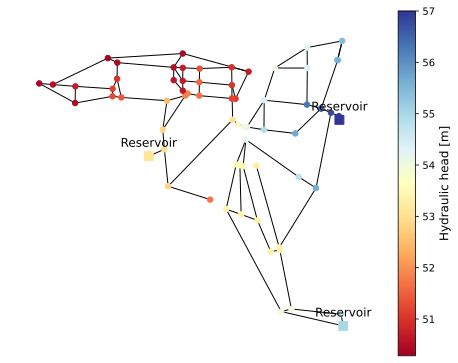

In [116]:
# set plotting values
t = 8
plot_type = 'head' # 'flow'
if plot_type == 'head':
    vals = h_schur
elif plot_type == 'flow':
    vals = q_schur

plot_network(wdn, plot_type=plot_type, vals=vals, t=t)

An accuracy comparison with EPANET is also presented below.

In [111]:
import matplotlib.pyplot as plt

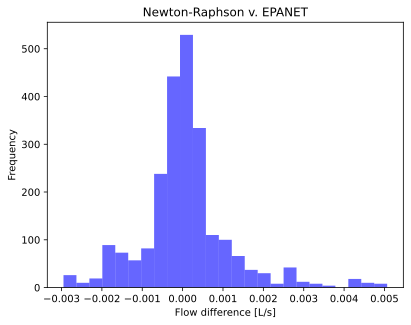

In [117]:
# Newton-Raphson v. EPANET: flow
qdiff_1 = q_nr.iloc[:, 1:] - q_epa.iloc[:, 1:]
qdiff_1_array = qdiff_1.values.flatten() * 1000
plt.hist(qdiff_1_array, bins = 25, color='blue', alpha=0.6)

# Set labels and title
plt.xlabel('Flow difference [L/s]')
plt.ylabel('Frequency')
plt.title('Newton-Raphson v. EPANET')

# Display the plot
plt.show()

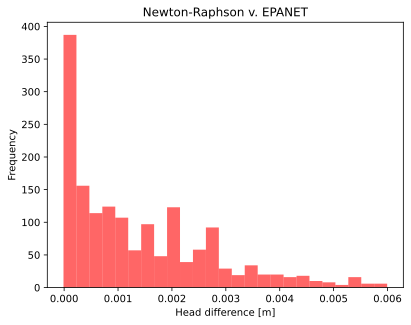

In [118]:
# Newton-Raphson v. EPANET: hydraulic head
hdiff_1 = h_nr.iloc[:, 1:] - h_epa.iloc[:, 1:]
hdiff_1_array = hdiff_1.values.flatten()
plt.hist(hdiff_1_array, bins = 25, color='red', alpha=0.6)

# Set labels and title
plt.xlabel('Head difference [m]')
plt.ylabel('Frequency')
plt.title('Newton-Raphson v. EPANET')

# Display the plot
plt.show()

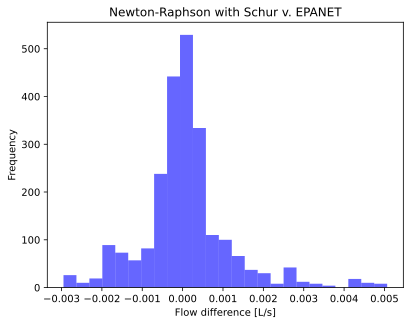

In [119]:
# Newton-Raphson with Schur v. EPANET: flow
qdiff_2 = q_schur.iloc[:, 1:] - q_epa.iloc[:, 1:]
qdiff_2_array = qdiff_2.values.flatten() * 1000
plt.hist(qdiff_2_array, bins = 25, color='blue', alpha=0.6)

# Set labels and title
plt.xlabel('Flow difference [L/s]')
plt.ylabel('Frequency')
plt.title('Newton-Raphson with Schur v. EPANET')

# Display the plot
plt.show()

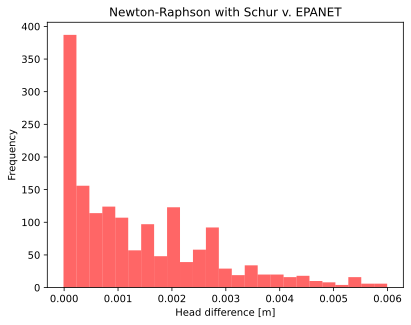

In [120]:
# Newton-Raphson with Schur v. EPANET: hydraulic head
hdiff_2 = h_schur.iloc[:, 1:] - h_epa.iloc[:, 1:]
hdiff_2_array = hdiff_2.values.flatten()
plt.hist(hdiff_2_array, bins = 25, color='red', alpha=0.6)

# Set labels and title
plt.xlabel('Head difference [m]')
plt.ylabel('Frequency')
plt.title('Newton-Raphson with Schur v. EPANET')

# Display the plot
plt.show()

### Future work items

This notebook could be extended to include:
1. Tanks (i.e. storage facilities with finite volume)
2. Hydraulic controls (e.g. pressure control valves, pumping)